In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.profiler
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchtyping import TensorType

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import random
import numpy


matplotlib.style.use('ggplot')
torch.set_printoptions(profile="full") #print full tensor
#torch.set_printoptions(profile="default")

In [4]:
random_seed = 0 
numpy.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(random_seed)
torch.random.manual_seed(random_seed)

In [5]:
class Encoder(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 42 x 42
        self.conv2 = nn.Conv2d(32, 32, 2, 2, 1)  # 21 x 21
        self.conv3 = nn.Conv2d(32, 64, 2, 2, 1)  # 11 x 11
        self.conv4 = nn.Conv2d(64, 64, 2, 2, 1)  # 6 x 6
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(3136, 256) # 6x6x 64 = 2304
        self.dense_means_logVar = nn.Linear(256, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print("conv1: " + str(h.size()))
        h = self.act(self.conv2(h))
        #print("conv2: " + str(h.size()))
        h = self.act(self.conv3(h))
        #print("conv3: " + str(h.size()))
        h = self.act(self.conv4(h))
        #print("conv4: " + str(h.size()))
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [6]:
class EncoderLikeDQN(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(EncoderLikeDQN, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=8, stride=4, padding=0)  # 20 x 20
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)  # 10 x 10
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  # 10 x 10
        self.flat1 = nn.Flatten()        
        self.dense1 = nn.Linear(6400, 512) # 10x10x 64 = 6400
        self.dense_means_logVar = nn.Linear(512, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print(h.size())
        h = self.act(self.conv2(h))
        #print(h.size())
        h = self.act(self.conv3(h))
        #print(h.size())
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [7]:
class EncoderL1(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(EncoderL1, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        #self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=8, stride=4, padding=0)  # 41 x 41
        #self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)  # 20 x 20 
        #self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  # 20 x 20
        #self.flat1 = nn.Flatten()        
        #self.dense1 = nn.Linear(25600, 4096) #
        #self.dense2 = nn.Linear(4096, 512) #
        #self.dense_means_logVar = nn.Linear(512, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)
        
        
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 84 x 84
        self.conv2 = nn.Conv2d(32, 32, 2, 2, 0)  # 43 x 43
        self.conv3 = nn.Conv2d(32, 64, 2, 2, 1)  # 22 x 22
        self.conv4 = nn.Conv2d(64, 64, 2, 2, 1)  # 12 x 12
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(9216, 3136) # 12x12x 64 = 9216
        self.dense2 = nn.Linear(3136, 256) 
        self.dense_means_logVar = nn.Linear(256, latent_dim*2)
        
        self.act = nn.ReLU(inplace=True)
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        print(f"inputsize: {x.size()}")
        h = self.act(self.conv1(x))
        print(f"conv 1: {h.size()}")
        h = self.act(self.conv2(h))
        print(f"conv 2: {h.size()}")
        h = self.act(self.conv3(h))
        print(f"conv 3: {h.size()}")
        h = self.act(self.conv4(h))
        print(f"conv 4: {h.size()}")
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        h = self.act(self.dense2(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [8]:
class Decoder(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 256)
        self.dense2 = nn.Linear(256, 3136)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(32, 32, 2, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, num_channels, 4, stride=2, padding=1)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("decoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = h.view(-1, 64, 7, 7)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print("Transpose 1: " + str(h.size()))
        h = self.act(self.upconv2(h))
        #print("Transpose 2: " + str(h.size()))
        h = self.act(self.upconv3(h))
        #print("Transpose 3: " + str(h.size()))
        img = self.upconv4(h)
        #print("Transpose 4: " + str(img.size()))
        return img

In [9]:
class DecoderLikeDQN(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(DecoderLikeDQN, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 512)
        self.dense2 = nn.Linear(512, 6400)        
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
        self.upconv3 = nn.ConvTranspose2d(32, num_channels, 8, 4, 0)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("encoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = h.view(-1, 64, 10, 10)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print(h.size())
        h = self.act(self.upconv2(h))
        #print(h.size())
        img = self.upconv3(h)
        #print(img.size())
        return img

In [10]:
class DecoderL1(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(DecoderL1, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 512)
        #self.dense2 = nn.Linear(512, 4096)
        #self.dense3 = nn.Linear(4096, 25600)        
        self.dense1 = nn.Linear(latent_dim, 256)
        self.dense2 = nn.Linear(256, 3136)
        self.dense3 = nn.Linear(3136, 9216)  
        
        #self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        #self.upconv2 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
        #self.upconv3 = nn.ConvTranspose2d(32, num_channels, 8, 4, 0)
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0)
        self.upconv4 = nn.ConvTranspose2d(32, num_channels, 4, stride=2, padding=1)
        
        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("encoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = self.act(self.dense3(h))
        #h = h.view(-1, 64, 20, 20)
        h = h.view(-1, 64, 12, 12)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print(h.size())
        h = self.act(self.upconv2(h))
        #print(h.size())
        h = self.act(self.upconv3(h))
        img = self.upconv4(h)        
        #print(img.size())
        return img

In [11]:
class VAE(nn.Module):
    def __init__(self, z_dim, num_channels, device, latent_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.device = device
        self.encoder = EncoderLikeDQN(z_dim, num_channels, latent_dim) # use "wrong" encoder
        self.decoder = DecoderLikeDQN(z_dim, num_channels, latent_dim)
        #self.encoder = Encoder(z_dim, num_channels, latent_dim) 
        #self.decoder = Decoder(z_dim, num_channels, latent_dim)
        #self.encoder = EncoderL1(z_dim, num_channels, latent_dim) 
        #self.decoder = DecoderL1(z_dim, num_channels, latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        self.mse = 0
        self.bce = 0
        self.tc = 0
        self.to(device)
        #self.rec_loss = nn.MSELoss() #try BCE Loss
        #self.rec_loss = nn.BCELoss()
        self.rec_loss = nn.BCEWithLogitsLoss() #clamp input values betweeen 0 & 1 use without sigmoid after last output
        
        
    def gaussian_log_density(self, z_sampled: TensorType["batch", "num_latents"],
                         z_mean: TensorType["batch", "num_latents"],
                         z_logvar: TensorType["batch", "num_latents"]):
        normalization = torch.log(torch.tensor(2. * numpy.pi))
        inv_sigma = torch.exp(-z_logvar)
        tmp = (z_sampled - z_mean)
        return -0.5 * (tmp * tmp * inv_sigma + z_logvar + normalization)    

    def total_correlation(self, z: TensorType["batch", "num_latents"],
                      z_mean: TensorType["batch", "num_latents"],
                      z_logvar: TensorType["batch", "num_latents"]) -> torch.Tensor:
    
        batch_size = z.size(0)
        log_qz_prob = self.gaussian_log_density(z.unsqueeze(1), z_mean.unsqueeze(0), z_logvar.unsqueeze(0))

        log_qz_product = torch.sum(
            torch.logsumexp(log_qz_prob, dim=1),
            dim=1
        )
        log_qz = torch.logsumexp(
            torch.sum(log_qz_prob, dim=2),
            dim=1
        )
        return torch.mean(log_qz - log_qz_product)

    
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
       
        
    def num_channels(self):
        return self.encoder.num_channels
    
    def decode(self, reparam_z):
        
        return self.decoder(reparam_z)

    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        if torch.isnan(z).any():
            print("z has NaN")
            print(z)
            print("*************************************input saved***********")
            x = x.cpu().detach().numpy()
            numpy.save( "faulty_batch", x)

            
            
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        sigma = torch.exp(z[:, :, 1])
        reparam_z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * (sigma**2 + mu**2 - 2*torch.log(sigma) - 1).mean()
        self.tc = self.total_correlation(reparam_z, mu, logvar)
        
        #x_t = self.decoder(reparam_z).sigmoid()
        x_t = self.decoder(reparam_z) #No sigmoid if BCEWithLogitsLoss
        
        #if torch.isnan(x_t).any():
            #print(x_t)
        #pred = x_t.clamp(0, 1) #push values between 0 and 1
        #pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred) #vlt muss das noch rein
        
        #self.mse = self.rec_loss(x_t, x)
        self.bce = self.rec_loss(x_t, x)
        return mu, logvar, x_t
    
    # TODO: Passe diese Klasse noch an. Vlt geht damit das Kopieren zurück

Data

In [9]:
train_data = numpy.load('train_data100kMAR22.npy')
val_data = numpy.load('val_data20kMAR22.npy')

In [12]:
train_data = numpy.load(r"C:\Users\erics\Documents\Programme\Bachelorarbeit\L1train_data100kWithLabels.npz")['data']
val_data = numpy.load(r"C:\Users\erics\Documents\Programme\Bachelorarbeit\L1val_data20kBWithLabels.npz")['data']


Downsampling the Data
---


In [13]:
train_data2=train_data[:, 0::2,0::2] #downsample
val_data2=val_data[:, 0::2,0::2]

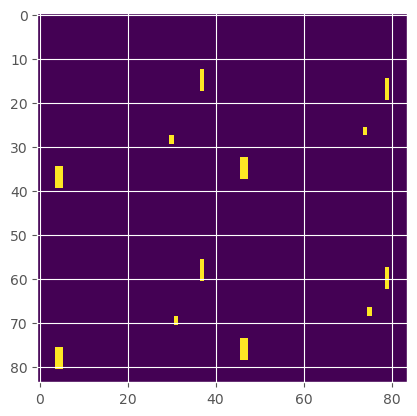

In [14]:
plt.imshow(train_data2[0])
plt.show()

In [22]:
from torch.nn.functional import interpolate
train_dataPy= torch.from_numpy(train_data)
train_dataPy= train_dataPy[:, None, :, :]
print(train_dataPy.size())
train_data3 = interpolate(train_dataPy, scale_factor=(0.5,0.5), mode='bilinear')

del train_dataPy
torch.cuda.empty_cache()

torch.Size([30000, 1, 168, 168])


C:\Users\erics\anaconda3\envs\PyTorchRL\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [29]:
train_data31 = train_data3.squeeze()
print(train_data31.size())

torch.Size([30000, 84, 84])


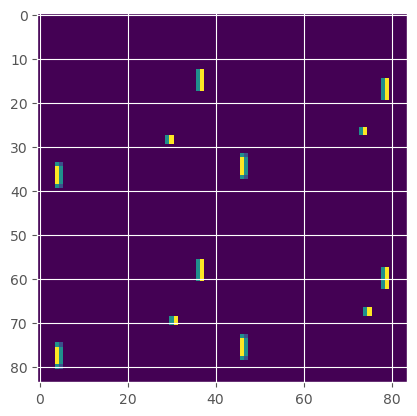

In [30]:
plt.imshow(train_data31[0])
plt.show()

Learning Setup

In [12]:
# leanring parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

latentDim = 64
epochs = 1
batch_size = 64
kl_wheight = 0.00064
beta = 3

if beta != 0 :
    tc_wheight = beta - 1
else: 
    tc_wheight = 0
beta = 1

lr = 0.0001

In [13]:
import datetime
x = datetime.datetime.now()
#newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/runLIKEDQNBeta{beta}Lat{latentDim}"
#newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/run1Beta{beta}Lat{latentDim}"
newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/runL1Lat{latentDim}"
newpath = newpath + "/output{x.day}-{x.month}"

if not os.path.exists(newpath):
    os.makedirs(newpath)
    
savingDir = newpath + "/epoch"

In [14]:
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True, #this instructs DataLoader to use pinned memory and enables faster and asynchronous memory copy from the host to the GPU.
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

In [15]:
#enc = Encoder(latentDim, 1, latentDim).to(device)
#dec = Decoder(latentDim, 1, latentDim).to(device)
#optEnc = optim.Adam(enc.parameters(), lr=lr)
#optDec = optim.Adam(dec.parameters(), lr=lr)

#print(enc)
#print(dec)

vae = VAE(latentDim, 1, device, latentDim).to(device)
opt = optim.Adam(vae.parameters(), lr=lr)

#criterion = nn.MSELoss(reduction='sum').to(device)

print(vae)

VAE(
  (encoder): EncoderL1(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (flat1): Flatten(start_dim=1, end_dim=-1)
    (dense1): Linear(in_features=9216, out_features=3136, bias=True)
    (dense2): Linear(in_features=3136, out_features=256, bias=True)
    (dense_means_logVar): Linear(in_features=256, out_features=128, bias=True)
    (act): ReLU(inplace=True)
  )
  (decoder): DecoderL1(
    (dense1): Linear(in_features=64, out_features=256, bias=True)
    (dense2): Linear(in_features=256, out_features=3136, bias=True)
    (dense3): Linear(in_features=3136, out_features=9216, bias=True)
    (upconv1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (upconv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), 

In [16]:
def final_loss(mse_loss, mu, logvar, beta, kl_wheight):
    """
    This function will add the reconstruction loss (MSELoss) and the (one could also take the mse loss instead of bce then we get a kind of PCA)
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*kl_wheight*KLD

In [17]:
def reparameterize(mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

In [18]:
def compute_generator_jacobian_image_optimized(model, embedding, epsilon_scale = 0.001, device="cpu"):
    raw_jacobian = compute_generator_jacobian_optimized(model, embedding, epsilon_scale, device)
    # shape is (latent_size, batch_size, numchannels = 1, im_size, im_size)
    jacobian = torch.sum(raw_jacobian, dim=2,keepdim = True)
    return(jacobian)

# output shape is (latent_dim, batch_size, model_output_shape)
def compute_generator_jacobian_optimized(model, embedding, epsilon_scale = 0.001, device="cpu"):
    batch_size = embedding.shape[0]
    latent_dim = embedding.shape[1]
    # repeat "tiles" like ABCABCABC (not AAABBBCCC)
    # note that we detach the embedding here, so we should hopefully
    # not be pulling our gradients further back than we intend
    encoding_rep = embedding.repeat(latent_dim + 1,1).detach().clone() #why hier kopie??
    # define our own repeat to work like "AAABBBCCC"
    delta = torch.eye(latent_dim)\
                .reshape(latent_dim, 1, latent_dim)\
                .repeat(1, batch_size, 1)\
                .reshape(latent_dim*batch_size, latent_dim)
    delta = torch.cat((delta, torch.zeros(batch_size,latent_dim))).to(device)
    # we randomized this before up to epsilon_scale,
    # but for now let's simplify and just have this equal to epsilon_scale.
    # I'd be _very_ impressed if the network can figure out to make the results
    # periodic with this frequency in order to get around this gradient check.
    epsilon = epsilon_scale     
    encoding_rep += epsilon * delta
    recons = model.decode(encoding_rep)
    temp_calc_shape = [latent_dim+1,batch_size] + list(recons.shape[1:])
    recons = recons.reshape(temp_calc_shape)
    recons = (recons[:-1] - recons[-1])/epsilon
    return(recons)


def jacobian_loss_function(model, mu, logvar, device):
    # jacobian shape is (latent_dim, batch_size, output_model_shape)
    # where the first batch_size rows correspond to the first latent dimension, etc.
    jacobian = compute_generator_jacobian_optimized(model, mu, epsilon_scale = 0.001, device=device)
    #print(jacobian.shape)
    latent_dim = jacobian.shape[0]
    batch_size = jacobian.shape[1]
    jacobian = jacobian.reshape((latent_dim, batch_size, -1))
    obs_dim = jacobian.shape[2]
    loss = torch.sum(torch.abs(jacobian))/batch_size
    assert len(loss.shape)==0, "loss should be a scalar"
    return(loss)


Training Loop

In [19]:
#def fit(enc, dec, dataloader):
def fit(vae, dataloader):
    #enc.train()
    #dec.train()
    vae.train
    running_loss = 0.0
   # with torch.profiler.profile(schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=10),
   #                             on_trace_ready=torch.profiler.tensorboard_trace_handler('C:/Users/erics/Documents/Programme/Bachelorarbeit/Profiler/BVAE/bestermann_MAR9_VAE_Class_Run8_runningLoss/'),
   #                             record_shapes=True,
   #                             profile_memory=True,
   #                             with_stack=True) as prof: 
        
   #     prof.start()
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data = data.to(device)
        data = data[:, None, :, :]

        #optEnc.zero_grad()
        #optDec.zero_grad()
        opt.zero_grad(set_to_none=True)
        #opt.zero_grad()

      #  interData = enc(data)
      #  sample, mu, logvar = interData
        #interData = reparameterize(mu, logvar)
      #  reconstruction = dec(sample)
        mu, logvar, reconstruction = vae(data)        

        #mse_loss = criterion(reconstruction, data)
        #loss = final_loss(mse_loss, mu, logvar, beta, kl_wheight = dataloader.batch_size/len(train_data))
        #kl_wheight = dataloader.batch_size/len(train_data) fixer hyperparameter
        #loss = kl_wheight * beta * vae.kl + vae.mse
        loss = kl_wheight * beta * vae.kl + vae.bce + tc_wheight * vae.tc
        loss += jacobian_loss_function(vae, mu, logvar, device)

        #running_loss += loss.item()
        running_loss += loss.detach().cpu().numpy() # faster with detach().cpu().numpy() but double the copied amount just for plotting purposes
        loss.backward()
      #  optEnc.step()
      #  optDec.step()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.5, norm_type=2.0) #args.clip) #clipping gradient
        opt.step()
        #print(opt.param_groups[0]['lr'])

       #     prof.step()
       #     if(i > 100):
       #         break
       # prof.stop()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [20]:
#def validate(enc, dec, dataloader):
def validate(vae, dataloader):
    #enc.eval()
    #dec.eval()
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data = data.to(device)
            data = data[:, None, :, :]
            
          #  interData = enc(data)
          #  sample, mu, logvar = interData
          #  reconstruction = dec(sample)
                
          #  mse_loss = criterion(reconstruction, data)
          #  loss = final_loss(mse_loss, mu, logvar, beta, kl_wheight = dataloader.batch_size/len(val_data))
          #  running_loss += loss.item()
            mu, logvar, reconstruction = vae(data)        
            loss = kl_wheight * beta * vae.kl + vae.bce + tc_wheight * vae.tc
            loss += jacobian_loss_function(vae, mu, logvar, device)
            
            running_loss += loss.detach().cpu()
            
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 84, 84)[:8], 
                                  reconstruction.view(batch_size, 1, 84, 84)[:8]))
                save_image(both.cpu(), savingDir + f"{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [21]:
train_loss = []
val_loss = []
torch.backends.cudnn.benchmark = True #choose best kernel for computation

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    #train_epoch_loss = fit(enc, dec, train_loader)
    #val_epoch_loss = validate(enc, dec, val_loader)
    
    train_epoch_loss = fit(vae, train_loader)
    val_epoch_loss = validate(vae, val_loader)
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 1


  0%|                                                                                          | 0/234 [00:00<?, ?it/s]

inputsize: torch.Size([64, 1, 84, 168])
conv 1: torch.Size([64, 32, 42, 84])
conv 2: torch.Size([64, 32, 21, 42])
conv 3: torch.Size([64, 64, 11, 22])
conv 4: torch.Size([64, 64, 6, 12])


  0%|                                                                                          | 0/234 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4608 and 9216x3136)

* Auslastung GPU: copy ~90%, vram 100% ( 2GB), 3D 0%
* Auslastung CPU: ~25 %

In [19]:
faulty_batch = numpy.load('faulty_batch.npy')

In [20]:
for i in range(64):
    all_zeros = not faulty_batch[i].any()
    print(all_zeros)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


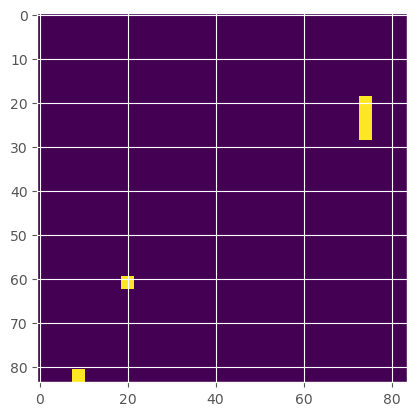

In [21]:
plt.imshow(faulty_batch[0][0])
plt.show()